# Analyze boreal biomass by polygonal zone
* updated to try COGReader and its zonal_statistics
* some test output from first clipping attempts here: /projects/shared-buckets/lduncanson/test_output/analyze_agb

In [1]:
!pip install rasterstats
!pip install geopandas==0.10.0
#!pip install -U rio-cogeo>=3.0.0

!pip install -U rio-tiler>=3.0.0
!pip install -U geojson-pydantic

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached geopandas-0.10.0-py2.py3-none-any.whl (1.0 MB)
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.9.0
    Uninstalling geopandas-0.9.0:
      Successfully uninstalled geopandas-0.9.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rio-cogeo 2.3.1 requires morecantile<2.2,>=2.1, but you have morecantile 3.1.2 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os

import rio_tiler
import rasterstats
import rasterio
import rasterio.mask
from rasterio.plot import show
from shapely.geometry import mapping
from rasterstats import zonal_stats
import geopandas as gpd
import pandas as pd
import fiona
from fiona.crs import from_epsg
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [6, 6]

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Read in vector file of polygon zones and boreal tiles
* get the tiles intersecting zones of interest

In [3]:
# For geopandas sjoin, need v0.10.0+
print(gpd.__version__)
# Need rio_tiler >3.0
print(rio_tiler.__version__)

0.10.0
3.1.4


### Get boreal tiles intersecting the ABoVE domain

CPU times: user 11.6 s, sys: 2.19 s, total: 13.8 s
Wall time: 14.3 s


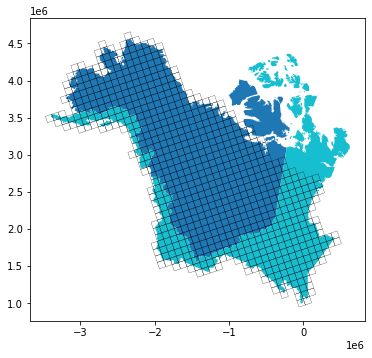

In [6]:
%%time
# Get the shp filename
# shp_fn = '/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/arc/bioclimate_dd.shp'
# shp_fn = '/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/data/hydrobasins/hybas_lev03_clip_above.gpkg'
# shp_fn = '/projects/my-public-bucket/misc_files/hybas_lake_ar_lev08_v1c.shp'
# shp_fn = '/projects/my-public-bucket/misc_files/wwf_terr_ecos.shp'
#shp_fn = '/projects/my-public-bucket/LVIS_ABoVE_spatial_footprints_2017_2019.gpkg'

# Reading in zones of interest
above_domain_fn = '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp'
above_domain_gdf = gpd.read_file(above_domain_fn)#.cx[-180:-150, 50:75]
above_domain_gdf['area_sq_km'] = above_domain_gdf.area / 1e6
above_domain_gdf.sort_values(by = 'area_sq_km', ascending=False, inplace=True)
above_crs = above_domain_gdf.crs

ax = above_domain_gdf.plot(column='Region')

# Reading in boreal tiles
boreal_tiles_fn = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
boreal_tiles = gpd.read_file(boreal_tiles_fn)
boreal_tiles_reprj = boreal_tiles.to_crs(above_crs)

# Join or intersection
if False:
    # we want the boreal tiles that intersect the above domain...
    boreal_tiles_above = boreal_tiles_reprj.sjoin(above_domain_gdf, how='left', predicate='overlaps')
else:
    # What i actually want is a selection based on an intersection
    #boreal_tiles_above = boreal_tiles_above[boreal_tiles_above.tile_num.isin(boreal_tiles.geometry.intersects(above_domain_gdf.geometry).tile_num.to_list())]
    
    selector1 = boreal_tiles_reprj.intersects(above_domain_gdf.iloc[0].geometry)
    selector2 = boreal_tiles_reprj.intersects(above_domain_gdf.iloc[1].geometry)
    #selector = boreal_tiles_reprj.overlay(above_domain_gdf, how='intersection')
    #selector = boreal_tiles_reprj.overlay(above_domain_gdf, how='intersection')
    boreal_tiles_above = boreal_tiles_reprj[(selector1) | (selector2)]
    
boreal_tiles_above.boundary.plot(color=None, edgecolor='k',linewidth = .25, ax=ax)


## Build a VRT of the boreal biomass COGs
* You want to use tindex master JSON to create a list for gdal
* it has geometry, tile_num, and the s3 path of the COG

In [8]:
indir = '/projects/shared-buckets/lduncanson/DPS_tile_lists'
# a writable outdir
outdir = '/projects/my-public-bucket/analyze_agb'

##### Might be something wrong with the AGB tindex json CRS?
* solution, just join to boreal_tindex?

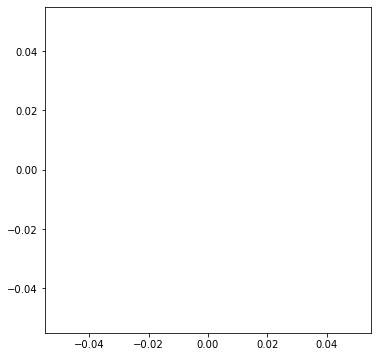

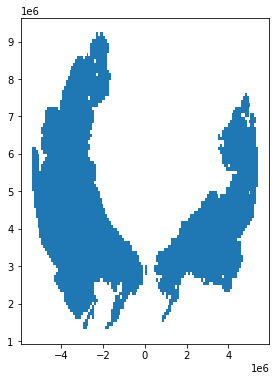

In [9]:
tile_json_fn = os.path.join(indir, "AGB_tindex_master.json")
tiles_json = gpd.read_file(tile_json_fn)

tiles_json.to_crs(above_crs).plot()
tiles_json.plot()

##### Seems like the tiles JSON is set as 4326, but has geometry in boreal_tiles crs
* TODO: correct the crs of the tiles json gdf

In [10]:
print(tiles_json.crs)
tiles_json.head()

epsg:4326


,tile_num,tile_version,tile_group,map_version,Unnamed: 0,local_path,s3,geometry
0,618,version 1,north america east,None,1,/projects/my-private-bucket/dps_output/run_bor...,s3://maap-ops-workspace/lduncanson/dps_output/...,"POLYGON ((4688522.00000 6993304.00000, 4778522..."
1,106,version 1,eurasia west,None,5,/projects/my-private-bucket/dps_output/run_bor...,s3://maap-ops-workspace/lduncanson/dps_output/...,"POLYGON ((-2511478.00000 8523304.00000, -24214..."
2,65,version 1,eurasia west,None,7,/projects/my-private-bucket/dps_output/run_bor...,s3://maap-ops-workspace/lduncanson/dps_output/...,"POLYGON ((-1791478.00000 8793304.00000, -17014..."
3,830,version 1,north america east,None,8,/projects/my-private-bucket/dps_output/run_bor...,s3://maap-ops-workspace/lduncanson/dps_output/...,"POLYGON ((3518522.00000 6543304.00000, 3608522..."
4,493,version 1,north america east,None,18,/projects/my-private-bucket/dps_output/run_bor...,s3://maap-ops-workspace/lduncanson/dps_output/...,"POLYGON ((4328522.00000 7263304.00000, 4418522..."


In [11]:
tiles_json_reprj = tiles_json.to_crs(boreal_tiles.crs)
print(tiles_json_reprj.crs)
tiles_json_reprj.head()

PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


,tile_num,tile_version,tile_group,map_version,Unnamed: 0,local_path,s3,geometry
0,618,version 1,north america east,None,1,/projects/my-private-bucket/dps_output/run_bor...,s3://maap-ops-workspace/lduncanson/dps_output/...,"POLYGON ((inf inf, inf inf, inf inf, inf inf, ..."
1,106,version 1,eurasia west,None,5,/projects/my-private-bucket/dps_output/run_bor...,s3://maap-ops-workspace/lduncanson/dps_output/...,"POLYGON ((inf inf, inf inf, inf inf, inf inf, ..."
2,65,version 1,eurasia west,None,7,/projects/my-private-bucket/dps_output/run_bor...,s3://maap-ops-workspace/lduncanson/dps_output/...,"POLYGON ((inf inf, inf inf, inf inf, inf inf, ..."
3,830,version 1,north america east,None,8,/projects/my-private-bucket/dps_output/run_bor...,s3://maap-ops-workspace/lduncanson/dps_output/...,"POLYGON ((inf inf, inf inf, inf inf, inf inf, ..."
4,493,version 1,north america east,None,18,/projects/my-private-bucket/dps_output/run_bor...,s3://maap-ops-workspace/lduncanson/dps_output/...,"POLYGON ((inf inf, inf inf, inf inf, inf inf, ..."


### Solution: just use boreal_tiles_v003
* but you need to join to JSON on tile_num to get the s3 path of the AGB COG

In [12]:
tile_group_region_string = "america"
tiles_subset = boreal_tiles[boreal_tiles['tile_group'].str.contains(tile_group_region_string)]\
                    .join(tiles_json[['tile_num','s3']].set_index('tile_num'), how='inner', on='tile_num')

## Map the selected boreal tiles with AGB COGs

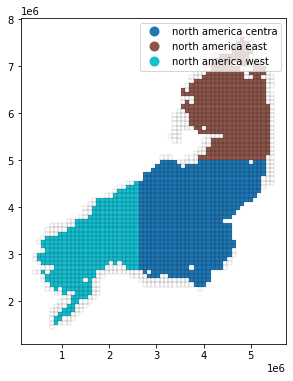

In [43]:
plt.rcParams['figure.figsize'] = [6, 6]

bnds = tiles_subset.total_bounds

ax=boreal_tiles.cx[bnds[0]:bnds[2], bnds[1]:bnds[3]].boundary.plot(color='black', linewidth=0.1)
tiles_subset.plot(column='tile_group', legend=True, ax=ax)


* this doesnt work. 'geometry' shows inf inf inf...

#### Use tiles selection to write a vrt list

In [13]:
# Write a vrt list
vrt_list = os.path.join(outdir,f"AGB_tindex_{tile_group_region_string}.txt")

with open(vrt_list, 'w') as f:
    
    for text in tiles_subset.s3.tolist():
        f.write(text.replace("s3:/","/vsis3") + '\n')

#### Build VRT of AGB COGs
* [-te xmin ymin xmax ymax]

In [78]:
vrt_fn = vrt_list.replace('.txt','.vrt')

#get the bbox as part of the gdalbuildvrt and define it, to save time calculating

extent = [int(b) for b in bnds]
extent_str = ' '.join(str(e) for e in extent)
extent_str
###!time gdalbuildvrt -b 1 -te 458521 1503304 5408522 7623304 -input_file_list $vrt_list $vrt_fn
#!time gdalbuildvrt -b 1 -te $extent_str -input_file_list $vrt_list $vrt_fn

0...10...20...30...40...50...60...70...80...90...100 - done.

real	4m16.724s
user	0m4.146s
sys	0m0.530s


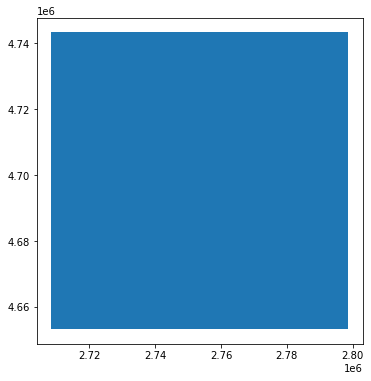

In [80]:
test_zone = tiles_subset[tiles_subset.tile_num == 1983]#

test_zone.plot()

# Use rasterstats to access and analyze AGB VRT

* Build dictionary for each set of input
    * input zones, input regions that contains zones of interest, VRT of COGs
* Select a dictionary to run
    * verify you have the input info you want
* Perform the zone selections
    * verify the input are in same CRS
    * verify you have the zones you want

### Build dictionaries of zonal stats inputs

In [14]:
vrt_fn = '/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt'

ZONAL_STATS_DICT = {'ZONE_NAME':'','ZONE_FN':'','REGION_NAME':'','REGION_FN':'','RASTER_NAME':'','RASTER_FN':''}
ZONAL_STATS_DICT_LIST = [
    {
            'ZONE_NAME': 'boreal_tiles_v003',
            'ZONE_FN': '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',
            'REGION_NAME': 'above',
            'REGION_FN': '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp',
            'REGION_SEARCH_COL':'Region',
            'REGION_SEARCH_STR':'Region',
            'RASTER_DATASET_ID': 'biomass_prelim',
            'RASTER_FN': vrt_fn
    },
    {
            'ZONE_NAME': 'boreal_tiles_v003',
            'ZONE_FN': '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',
            'REGION_NAME': 'boreal_na',
            'REGION_FN': '/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson',
            'REGION_SEARCH_COL':'REALM',
            'REGION_SEARCH_STR':'NA',
            'RASTER_DATASET_ID': 'biomass_prelim',
            'RASTER_FN': vrt_fn
    },
    {
            'ZONE_NAME': 'hybas_lev06',
            'ZONE_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_lev06_v1c.shp',
            'REGION_NAME': 'above',
            'REGION_FN': '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp',
            'REGION_SEARCH_COL':'Region',
            'REGION_SEARCH_STR':'Region',
            'RASTER_DATASET_ID': 'biomass_prelim',
            'RASTER_FN': vrt_fn
    },
    {
            'ZONE_NAME': 'hybas_lev06',
            'ZONE_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_lev06_v1c.shp',
            'REGION_NAME': 'above',
            'REGION_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_lev03_v1c.shp',
            'REGION_SEARCH_COL':'Region',
            'REGION_SEARCH_STR':'Region',
            'RASTER_DATASET_ID': 'biomass_prelim',
            'RASTER_FN': vrt_fn
    },
]


## Select input dictionary from list

In [15]:
ZONAL_STATS_DICT = ZONAL_STATS_DICT_LIST[3]
ZONAL_STATS_DICT

{'ZONE_NAME': 'hybas_lev06',
 'ZONE_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_lev06_v1c.shp',
 'REGION_NAME': 'above',
 'REGION_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_lev03_v1c.shp',
 'REGION_SEARCH_COL': 'Region',
 'REGION_SEARCH_STR': 'Region',
 'RASTER_DATASET_ID': 'biomass_prelim',
 'RASTER_FN': '/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt'}

## Create a gdf list that holds level 3 hybas regions used to group level 6 hybas zones

In [16]:
vector_gdf = gpd.read_file(ZONAL_STATS_DICT['REGION_FN']).cx[-180:180,45:90]
vector_gdf.info()

geoms_list = []
zone_name_list = []
gdf_list = []
zone_field_name = 'HYBAS_ID'

for idx in vector_gdf.index:
    #print(idx)
    geom =  vector_gdf.loc[idx].geometry
    zonename =  vector_gdf.loc[idx][zone_field_name]
    
    if geom not in geoms_list:
        #gpd.GeoSeries(geom).plot()
        geoms_list.append(geom)
        zone_name_list.append(zonename)
        gdf_list.append(gpd.GeoSeries(geom))

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 97 entries, 0 to 161
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   HYBAS_ID   97 non-null     int64   
 1   NEXT_DOWN  97 non-null     int64   
 2   NEXT_SINK  97 non-null     int64   
 3   MAIN_BAS   97 non-null     int64   
 4   DIST_SINK  97 non-null     float64 
 5   DIST_MAIN  97 non-null     float64 
 6   geometry   97 non-null     geometry
dtypes: float64(2), geometry(1), int64(4)
memory usage: 6.1 KB


{'ZONE_NAME': 'hybas_lev06',
 'ZONE_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_GLOBAL_lev06_v1c.shp',
 'REGION_NAME': 'above',
 'REGION_FN': 0    MULTIPOLYGON (((138.20694 54.69583, 138.20201 ...
 dtype: geometry,
 'REGION_SEARCH_COL': 'Region',
 'REGION_SEARCH_STR': None,
 'RASTER_DATASET_ID': 'biomass_prelim',
 'RASTER_FN': '/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt'}

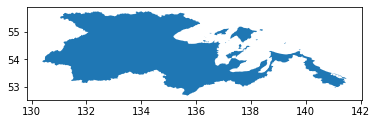

In [17]:
gdf_list[0].plot()
ZONAL_STATS_DICT.update({'REGION_FN': gdf_list[0], 'REGION_SEARCH_STR': None})
ZONAL_STATS_DICT

In [18]:
import sys
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils

In [19]:
ExtractUtils.get_raster_zonalstats(ZONAL_STATS_DICT)

TypeError: get_raster_zonalstats() missing 1 required positional argument: 'vrt_fn'

### Perform zone selections

# of hybas_lev06 zones in above for zonal stats:	1076


/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if isinstance(result, DataFrame) and geo_col in result:


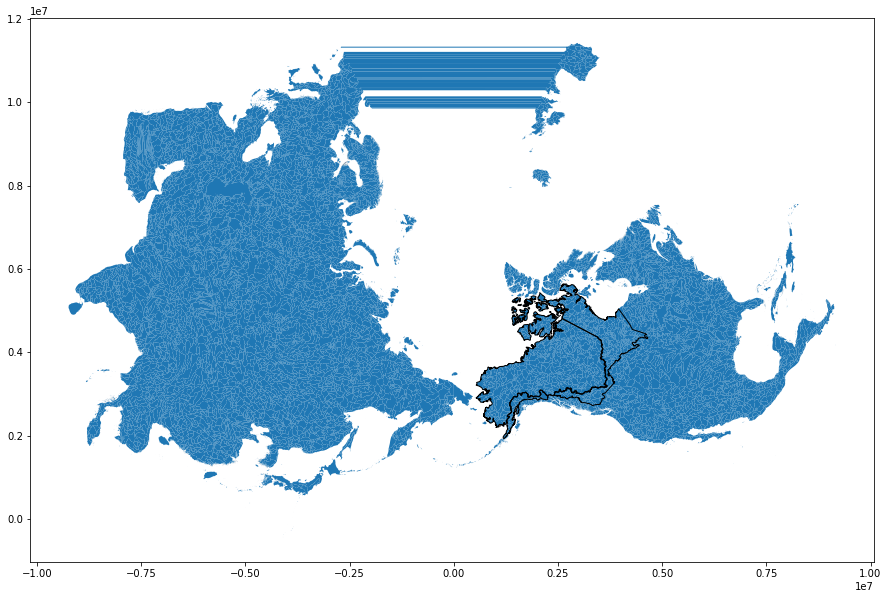

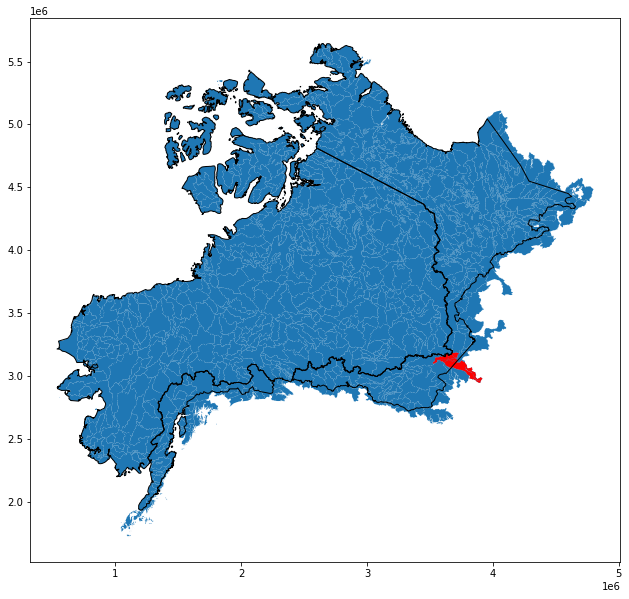

In [312]:
# Get the raster crs
with rasterio.open(ZONAL_STATS_DICT['RASTER_FN'], mode='r') as src:
    raster_crs = src.crs

 # Reproject the zones and the regions to the raster crs
in_gdf = gpd.read_file(ZONAL_STATS_DICT['ZONE_FN']).to_crs(raster_crs)
region_gdf = gpd.read_file(ZONAL_STATS_DICT['REGION_FN']).to_crs(raster_crs)

# Plot of zones with regions in the raster crs
ax = in_gdf.plot()
region_gdf.boundary.plot(linewidth=1, color='black', ax=ax)

if 'LAKE' in in_gdf.columns.to_list():
    # Remove lakes
    in_gdf = in_gdf[in_gdf.LAKE == 0]
    
#selector1 = in_gdf.intersects(region_gdf.to_crs(in_gdf.crs).iloc[0].geometry)
#selector2 = in_gdf.intersects(region_gdf.to_crs(in_gdf.crs).iloc[1].geometry)

# Select the zones bsed on the region string
#in_gdf = in_gdf[(selector1) | (selector2)].to_crs(raster_crs)
region_gdf_subset = region_gdf[region_gdf[ ZONAL_STATS_DICT['REGION_SEARCH_COL'] ].str.contains(ZONAL_STATS_DICT['REGION_SEARCH_STR']) ]
region_gdf_subset['dissolve_field'] = 'for intersect'

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = in_gdf.intersects(region_gdf_subset.dissolve(by='dissolve_field').iloc[0].geometry)

in_gdf_subset = in_gdf[selector]
print(f"# of {ZONAL_STATS_DICT['ZONE_NAME']} zones in {ZONAL_STATS_DICT['REGION_NAME']} for zonal stats:\t{len(in_gdf_subset)}")

# If units of in_gdf are meters
in_gdf_subset['area_sq_km'] = in_gdf_subset.area / 1e6

# Reproject the zones and the regions to the raster crs

in_gdf_subset_r_prj = in_gdf_subset.to_crs(raster_crs)
region_gdf_subset_r_prj = region_gdf_subset.to_crs(raster_crs)

# Plot the zones across the region in the crs of the raster
ax = in_gdf_subset_r_prj.plot()
region_gdf_subset_r_prj.boundary.plot(ax=ax, linewidth=1, color='black')
in_gdf_subset_r_prj.head().plot(ax=ax, linewidth=1, color='red')

### Run zonal_stats and attach to output geodataframe
* TODO: mask vrt_fn with 'Trees' class from s3 Worldcover

In [313]:
%%time
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
out_csv_fn = f"/projects/my-public-bucket/analyze_agb/zonal.{ZONAL_STATS_DICT['RASTER_DATASET_ID']}.{ZONAL_STATS_DICT['ZONE_NAME']}.{ZONAL_STATS_DICT['REGION_NAME']}.{nowtime}.geojson"

print(f"Doing zonal stats:\nVRT:\t\t{ZONAL_STATS_DICT['RASTER_FN']}\nZONE TYPE:\t{ZONAL_STATS_DICT['ZONE_NAME']}\nREGION:\t\t{ZONAL_STATS_DICT['REGION_NAME']}\nSaving to:\t{out_csv_fn}")

# Use join
out_gdf = in_gdf_subset_r_prj.reset_index(drop=True).join(
    pd.DataFrame(
        rasterstats.zonal_stats(
            vectors=in_gdf_subset_r_prj['geometry'], #.head()
            raster=ZONAL_STATS_DICT['RASTER_FN'], 
            stats=['max','mean', 'median','std','min','sum','count']
        )
    )
)

out_gdf.to_file(out_csv_fn, driver='GeoJSON')
ax = out_gdf.plot('median', cmap='viridis', legend=True, vmin=0, vmax=250, ax=ax)
print(ax)

Current time:	202204212128
Doing zonal stats:
VRT:		/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt
ZONE TYPE:	hybas_lev06
REGION:		above
Saving to:	/projects/my-public-bucket/analyze_agb/zonal.biomass_prelim.hybas_lev06.above.202204212128.geojson
AxesSubplot(0.125,0.125;0.62x0.755)
CPU times: user 22.6 s, sys: 6.27 s, total: 28.8 s
Wall time: 1min 43s


<Figure size 1800x720 with 0 Axes>

### Check the output you just ran

In [316]:
plt.rcParams['figure.figsize'] = [25, 10]


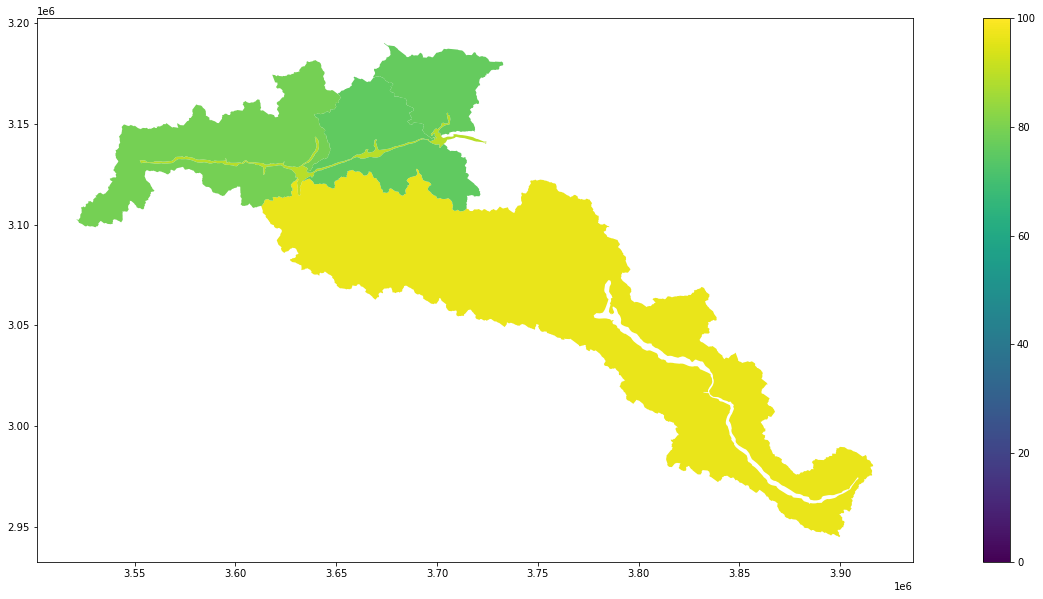

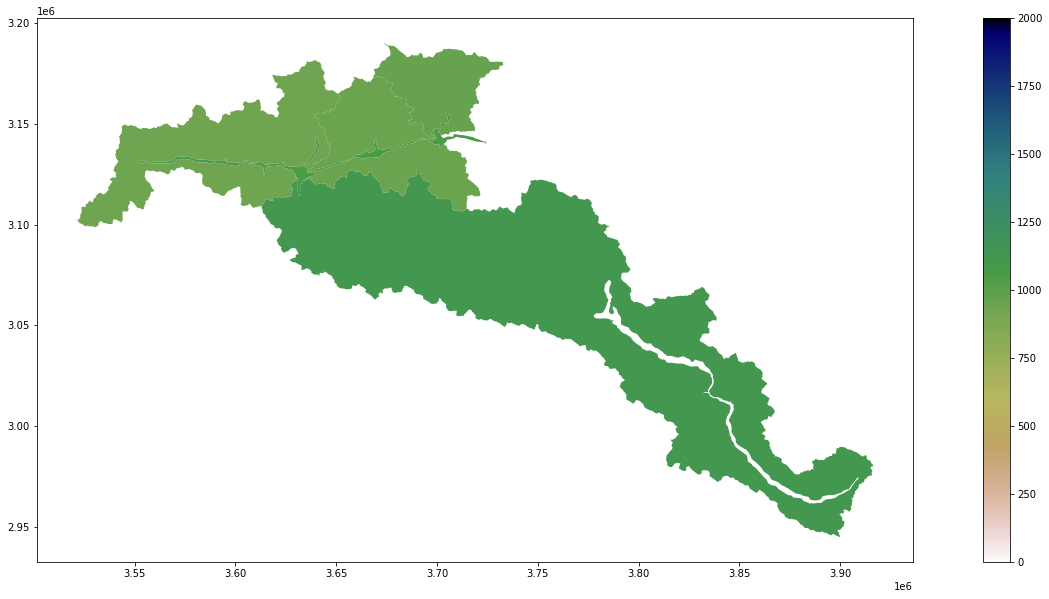

In [321]:
# get median of AGB in Mg/ha
out_gdf.plot('median', cmap='viridis', legend=True, vmin=0, vmax=100)

# Get the total tile AGB in Mg
out_gdf['total_Mg'] =  out_gdf['sum']  / ( out_gdf['count'] * 0.09)  # Mg_ha_sum / num_pixels * area_ha per pixel
ax = out_gdf.plot(column='total_Mg', cmap='gist_earth_r', legend=True, vmin=0, vmax=2000)

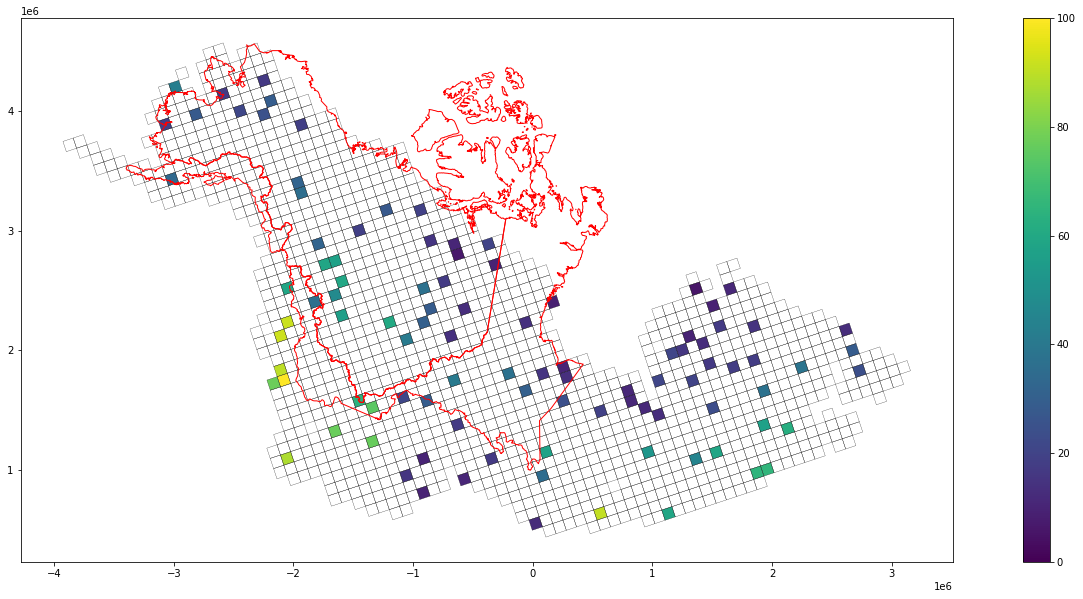

In [172]:
ax = tiles_subset.to_crs(in_gdf.crs).to_crs(above_domain_gdf.crs).boundary.plot(color=None, edgecolor='k',linewidth = .25)
ax = out_gdf.to_crs(in_gdf.crs).to_crs(above_domain_gdf.crs).plot('median', cmap='viridis', legend=True, vmin=0, vmax=100, ax=ax)
above_domain_gdf.to_crs(in_gdf.crs).to_crs(above_domain_gdf.crs).boundary.plot(color=None, edgecolor='red',linewidth = 1, ax=ax)

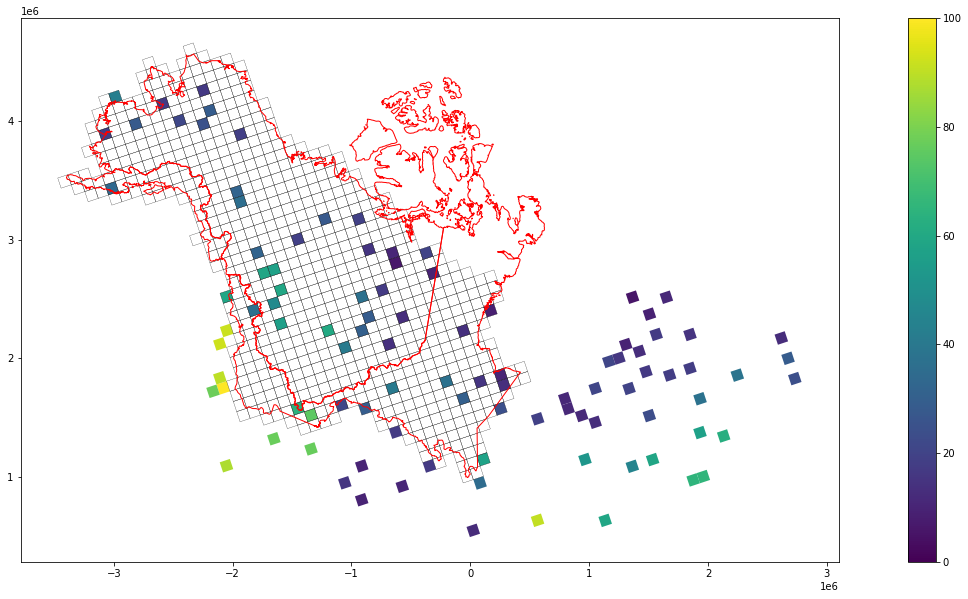

In [173]:
ax = boreal_tiles_above.to_crs(in_gdf.crs).to_crs(above_domain_gdf.crs).boundary.plot(color=None, edgecolor='k',linewidth = .25)
ax = out_gdf.to_crs(in_gdf.crs).to_crs(above_domain_gdf.crs).plot('median', cmap='viridis', legend=True, vmin=0, vmax=100, ax=ax)
above_domain_gdf.to_crs(in_gdf.crs).to_crs(above_domain_gdf.crs).boundary.plot(color=None, edgecolor='red',linewidth = 1, ax=ax)

## Map the total AGB in Mg

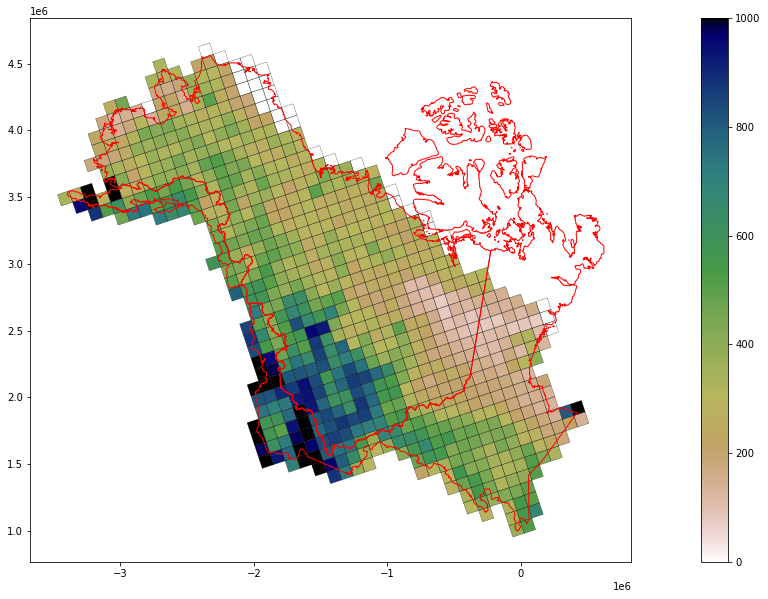

In [174]:
out_gdf_above = gpd.read_file('/projects/my-public-bucket/analyze_agb/zonal.biomass_prelim.boreal_tiles_v003.above.geojson')

# https://stackoverflow.com/questions/38961816/geopandas-set-crs-on-points
#out_gdf_above_tmp = gpd.GeoDataFrame(out_gdf_above_tmp, geometry=out_gdf_above_tmp.geometry, crs=out_gdf_above_tmp.crs)
out_gdf_above.set_crs(in_gdf.crs, inplace=True, allow_override=True)

#out_gdf_above = out_gdf_above.to_crs(above_domain_gdf.crs)
out_gdf_above = out_gdf_above.to_crs(in_gdf.crs).to_crs(above_domain_gdf.crs)

# Get the total tile AGB in Mg
out_gdf_above['total_Mg'] =  out_gdf_above['sum']  / ( out_gdf_above['count'] * 0.09)  # Mg_ha_sum / num_pixels * area_ha per pixel

ax = out_gdf_above.plot(column='total_Mg', cmap='gist_earth_r', legend=True, vmin=0, vmax=1000)
ax = out_gdf_above.boundary.plot(color=None, edgecolor='k',linewidth = .25, ax =ax)
above_domain_gdf.boundary.plot(color=None, edgecolor='red',linewidth = 1, ax =ax)

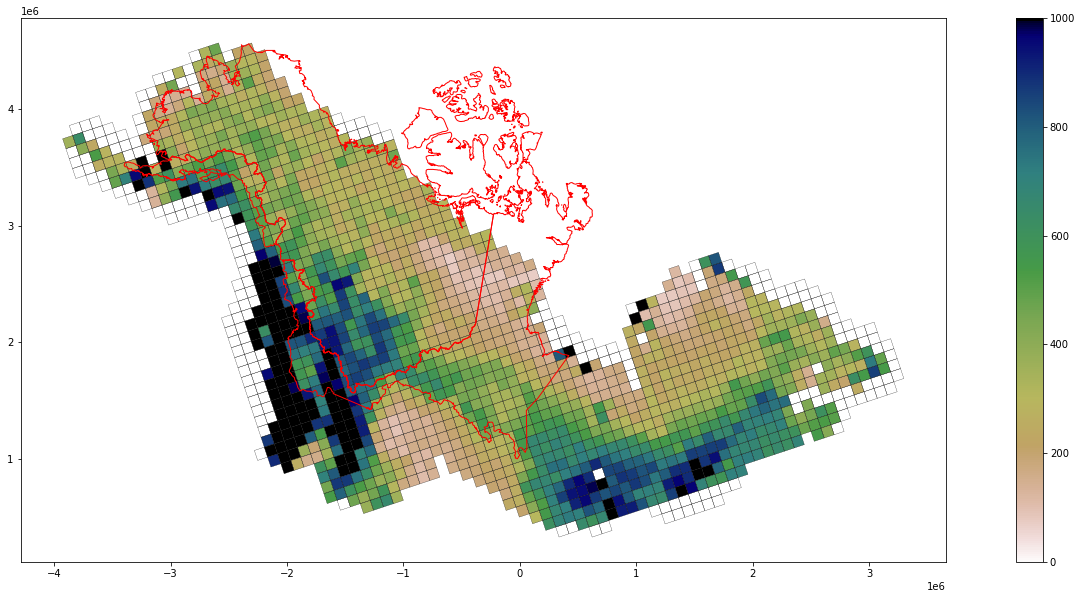

In [175]:
out_gdf_na = gpd.read_file('/projects/my-public-bucket/analyze_agb/zonal.biomass_prelim.boreal_tiles_v003.na.202204071745.geojson')
out_gdf_na.set_crs(in_gdf.crs, inplace=True, allow_override=True)

out_gdf_na = out_gdf_na.to_crs(in_gdf.crs).to_crs(above_domain_gdf.crs)

# Get the total tile AGB in Mg
out_gdf_na['total_Mg'] =  out_gdf_na['sum']  / ( out_gdf_na['count'] * 0.09)  # Mg_ha_sum / num_pixels * area_ha per pixel
ax = out_gdf_na.plot(column='total_Mg', cmap='gist_earth_r', legend=True, vmin=0, vmax=1000)
out_gdf_na.boundary.plot(color=None, edgecolor='k',linewidth = .25, ax =ax)
above_domain_gdf.boundary.plot(color=None, edgecolor='red',linewidth = 1, ax =ax)

# Below: Notes and unused cells

### Using COGReader to access and analze VRT
* select a test zone
* read the VRT: https://cogeotiff.github.io/rio-tiler/advanced/feature/
* get basic image stats: https://cogeotiff.github.io/rio-tiler/examples/Using-rio-tiler/
* get zonal stats: https://cogeotiff.github.io/rio-tiler/advanced/zonal_stats/

In [ ]:
from rio_tiler.io import COGReader
from rio_tiler.models import ImageData

Select a test zone

Read COG portion that intersects a feature

In [ ]:
with COGReader(vrt_fn) as cog:
    # Read data for a given geojson polygon
    z = cog.feature(test_zone.to_json())  # we limit the max_size to 1024

Test some basic image stats with COGReader

In [ ]:
with COGReader(vrt_fn) as cog:
    meta = cog.statistics(max_size=256)

    assert isinstance(meta, dict)
    print(list(meta))
    print(meta["1"].dict())

### Enable Zonal Stats with COGReader

In [55]:
import attr
from typing import Any, Union, Optional, List, Dict

from rio_tiler import io
from rio_tiler.utils import get_array_statistics
from rio_tiler.models import BandStatistics

from geojson_pydantic.features import Feature, FeatureCollection
from geojson_pydantic.geometries import Polygon

class COGReader(io.COGReader):
    """Custom COGReader with zonal_statistics method."""

    def zonal_statistics(
            self,
            geojson: Union[FeatureCollection, Feature],
            categorical: bool = False,
            categories: Optional[List[float]] = None,
            percentiles: List[int] = [2, 98],
            hist_options: Optional[Dict] = None,
            max_size: int = None,
            **kwargs: Any,
        ) -> FeatureCollection:
            """Return statistics from GeoJSON features.

            Args:
                geojson (Feature or FeatureCollection): a GeoJSON Feature or FeatureCollection.
                categorical (bool): treat input data as categorical data. Defaults to False.
                categories (list of numbers, optional): list of categories to return value for.
                percentiles (list of numbers, optional): list of percentile values to calculate. Defaults to `[2, 98]`.
                hist_options (dict, optional): Options to forward to numpy.histogram function.
                max_size (int, optional): Limit the size of the longest dimension of the dataset read, respecting bounds X/Y aspect ratio. Defaults to None.
                kwargs (optional): Options to forward to `self.preview`.

            Returns:
                FeatureCollection

            """
            kwargs = {**self._kwargs, **kwargs}

            hist_options = hist_options or {}

            # We transform the input Feature to a FeatureCollection
            if not isinstance(geojson, FeatureCollection):
                geojson = FeatureCollection(features=[geojson])

            for feature in geojson:
                # Get data overlapping with the feature (using COGReader.feature method)
                data = self.feature(
                    feature.dict(exclude_none=True),
                    max_size=max_size,
                    **kwargs,
                )

                # Get band statistics for the data
                stats = get_array_statistics(
                    data.as_masked(),
                    categorical=categorical,
                    categories=categories,
                    percentiles=percentiles,
                    **hist_options,
                )

                # Update input feature properties and add the statistics
                feature.properties = feature.properties or {}
                feature.properties.update(
                    {
                        "statistics": {
                            f"{data.band_names[ix]}": BandStatistics(
                                **stats[ix]
                            )
                            for ix in range(len(stats))
                        }
                    }
                )

            return geojson


In [53]:
import rio_tiler
print(rio_tiler.__version__)

3.1.2


# Test output from first clipping attempts

In [68]:
def get_gdf_lists(input_gdf, zone_field_name, SHOW_CLIP=False):
    '''
    From the input gdf get:
        geoms_list: the geoms (features) that you will use to clip
        zone_name_list: the names of the geoms (features)
    '''
    geoms_list = []
    zone_name_list = []

    for idx in input_gdf.index:
        #print(idx)
        geom =  input_gdf.loc[idx].geometry
        zonename =  input_gdf.loc[idx][zone_field_name]
        print(zone_field_name, zonename)
        if geom not in geoms_list:
            if SHOW_CLIP:
                gpd.GeoSeries(geom).plot()
            geoms_list.append(geom)
            zone_name_list.append(zonename)

    print(f'# of indiv features: {len(geoms_list)}')
    return [geoms_list, zone_name_list]

def do_clip(r_fn, input_gdf, zone_field_name, indir, outdir, vector_fn, SHOW_CLIP = True):
    
    geoms_list, zone_name_list = get_gdf_lists(input_gdf, zone_field_name, SHOW_CLIP = False)
    
    feature_pass_list = []
    feature_fail_list = []
    no_raster_intersection_list = []

    with rasterio.open(r_fn, "r") as r:

        for idx, zone_name in enumerate(zone_name_list):
            print(zone_name)
            geom = geoms_list[idx]
            
            feature_gdf = None
            try:
                feature_gdf = gpd.GeoDataFrame({'name':zone_name, 'geometry':geom}, crs=from_epsg(4326)) #index=[0], 
                feature_gdf.plot()
                # Reproject feature_gdf to raster crs
                feature_gdf = feature_gdf.to_crs(r.crs)
            except ValueError:
                print(f"Cant get geodataframe for feature {zone_name}")
                feature_fail_list.append(zone_name)
                
                continue

            zone_name = f'{zone_name:03}'
            out_r_fn = os.path.join(os.path.split(r_fn.replace(indir, outdir))[0] , os.path.split(r_fn)[1].replace(os.path.splitext(r_fn)[1], '_'+vector_fn+'_'+zone_name+'.tif'))

            try:

                out_image, out_transform = rasterio.mask.mask(dataset=r, shapes=feature_gdf.geometry, crop=True)

                # Copy the metadata
                out_meta = r.meta.copy()
                out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform,
                         "crs":r.crs.to_proj4()}
                                 )
                with rasterio.open(out_r_fn, "w", **out_meta) as out_r:
                    out_r.write(out_image)

                    print("Zone", zone_name, "clip of",  os.path.split(r_fn)[1])
                    print("Writing clipped subset to", out_r_fn)
                    feature_pass_list.append(zone_name)

                    #show(out_r, cmap='viridis') # <-- this show() is not working here..need to read the raster in again?

                # HERE IS WHERE WE CAN DO rasterstat's zonal_stats.
                if SHOW_CLIP:
                    show((rasterio.open(out_r_fn)), cmap='viridis')# <-- this show() works

            except ValueError:
                print(zone_name, " has no intersection with", os.path.split(r_fn)[1])
                no_raster_intersection_list.append(zone_name)
    print(f'# features that produced clips: {len(feature_pass_list)}')
    print(f'# features that failed to produce geodataframes: {len(feature_fail_list)}')
    print(f'# features that didnt have intersection with raster: {len(no_raster_intersection_list)}')

HYBAS_ID 8080000010
HYBAS_ID 8089023840
HYBAS_ID 8080000061
HYBAS_ID 8080000062
HYBAS_ID 8089051211
# of indiv features: 5
8080000010
Cant get geodataframe for feature 8080000010
8089023840
Cant get geodataframe for feature 8089023840
8080000061


/projects/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Zone 8080000061 clip of AGB_tindex.vrt
Writing clipped subset to /projects/my-public-bucket/test_output/analyze_agb/AGB_tindex_hybas_lev08_8080000061.tif


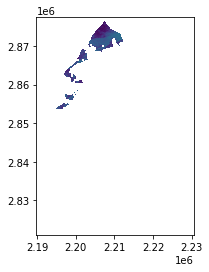

8080000062


/projects/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Zone 8080000062 clip of AGB_tindex.vrt
Writing clipped subset to /projects/my-public-bucket/test_output/analyze_agb/AGB_tindex_hybas_lev08_8080000062.tif


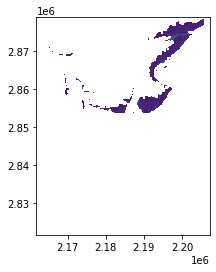

8089051211
Cant get geodataframe for feature 8089051211
# features that produced clips: 2
# features that failed to produce geodataframes: 3
# features that didnt have intersection with raster: 0


In [69]:
do_clip(r_fn, vector_gdf.head(), zone_field_name, indir, outdir, vector_file_name, SHOW_CLIP = True)